# Classification Evaluation

In [1]:
import pandas as pd

In [2]:
import sklearn

import numpy as np

from sklearn.model_selection import cross_val_score, GridSearchCV  
#cross_val_score to assess accuracy of model
#GridSearchCV 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [3]:
sklearn.set_config(display="diagram")

# 1. Import Data

In [4]:
df = pd.read_csv("datasets/titanic.csv", index_col="PassengerId")
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,Mr. Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,Mrs. John Bradley (Florence Briggs Thayer),female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,Miss. Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,Mrs. Jacques Heath (Lily May Peel),female,35.0,1,0,113803,53.1000,C123,S
5,0,3,Mr. William Henry,male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
len(df)

891

In [6]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)

# 2. Preprocessing

In [7]:
# Find and Impute Deck

import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [train_df, test_df]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U")  #U0 
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
# we can now drop the cabin feature
train_df = train_df.drop(['Cabin'], axis=1)
test_df = test_df.drop(['Cabin'], axis=1)

In [8]:
# Impute Age

data = [train_df, test_df]

for dataset in data:
    mean = train_df["Age"].mean()
    std = train_df["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = dataset["Age"].astype(int)
train_df["Age"].isnull().sum()

0

In [9]:
#Impute NAs
common_value = 'S'
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

data = [train_df, test_df]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

In [10]:
# Label-Encode Titles
data = [train_df, test_df]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)

In [11]:
# Label-Encode Titles
genders = {"male": 0, "female": 1}
data = [train_df, test_df]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

In [12]:
# Remove ticket column
train_df = train_df.drop(['Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)

In [13]:
# Label-Encode Ports
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_df, test_df]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

In [14]:
# Group Age
data = [train_df, test_df]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6  #7

In [15]:
# Group Fares
data = [train_df, test_df]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

# 3. Model Training

In [16]:
X_train = train_df.drop("Survived", axis=1)
y_train = train_df["Survived"]
X_test  = test_df.drop("Survived", axis=1).copy()
y_test = test_df["Survived"]

In [17]:
# Let's fit a basic model
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

scores = cross_val_score(lr, X_train, y_train)
scores

array([0.77622378, 0.81118881, 0.83802817, 0.79577465, 0.75352113])

In [18]:
np.mean(scores)

0.7949473062149119

In [19]:
#API Reference — scikit-learn 1.4.1 documentation   to choose tool to see how good the model is

from sklearn.metrics import accuracy_score, confusion_matrix
y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)
accuracy_score(y_test, y_pred)

0.7988826815642458

In [20]:
cf = confusion_matrix(y_test, y_pred)
cf

array([[100,  15],
       [ 21,  43]], dtype=int64)

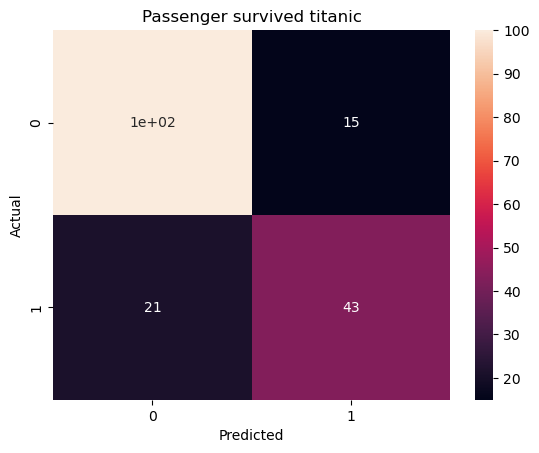

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf, annot=True)
plt.title('Passenger survived titanic')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

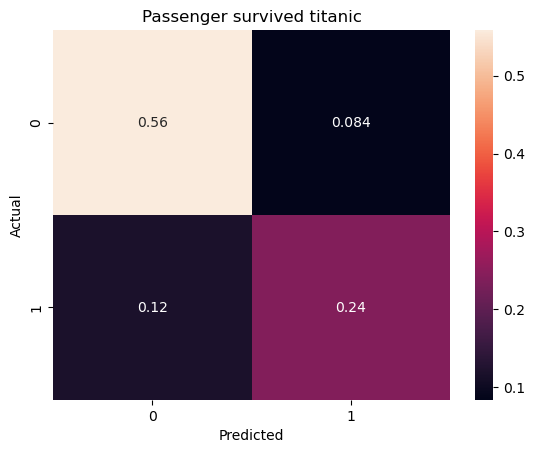

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf/np.sum(cf), annot=True)  #percentages that we did not get correctly
plt.title('Passenger survived titanic')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [23]:
y_prob

array([[0.93777705, 0.06222295],
       [0.8174528 , 0.1825472 ],
       [0.92606649, 0.07393351],
       [0.9023031 , 0.0976969 ],
       [0.92262791, 0.07737209],
       [0.9023031 , 0.0976969 ],
       [0.85193965, 0.14806035],
       [0.86444596, 0.13555404],
       [0.11745396, 0.88254604],
       [0.23759051, 0.76240949],
       [0.10198174, 0.89801826],
       [0.91040293, 0.08959707],
       [0.29415649, 0.70584351],
       [0.59223968, 0.40776032],
       [0.55103278, 0.44896722],
       [0.85520651, 0.14479349],
       [0.82061433, 0.17938567],
       [0.85254509, 0.14745491],
       [0.85254509, 0.14745491],
       [0.68101929, 0.31898071],
       [0.90416738, 0.09583262],
       [0.68101929, 0.31898071],
       [0.5307809 , 0.4692191 ],
       [0.88677733, 0.11322267],
       [0.9023031 , 0.0976969 ],
       [0.88186625, 0.11813375],
       [0.4082062 , 0.5917938 ],
       [0.58520781, 0.41479219],
       [0.92262791, 0.07737209],
       [0.2719861 , 0.7280139 ],
       [0.

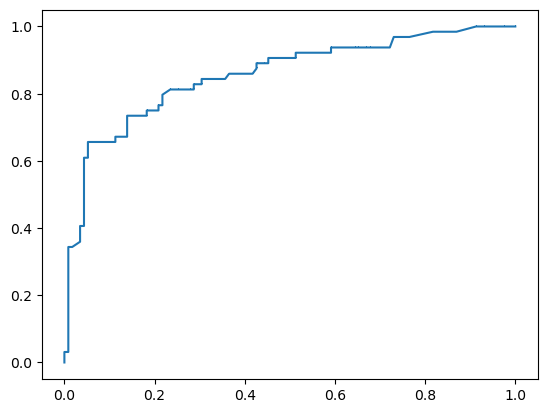

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score #auc:area under the curve

y_prob = lr.predict_proba(X_test)

lr_fpr, lr_tpr, _ = roc_curve(y_test, y_prob[:,1])  #fpr:false positive rate; tpr: true positive rate
plt.plot(lr_fpr, lr_tpr, marker=',')

In [25]:
from sklearn.metrics import average_precision_score
average_precision_score(y_test, y_pred)

0.615432659892121

# 4. Model Selection

In [26]:
# Let's find the best model

In [27]:
rf=RandomForestClassifier(random_state=42)
svc=SVC(random_state=42)
gbc=GradientBoostingClassifier(random_state=42)

clfs = {              #clfs stands for classifiers
    "rf": rf,
    "SVC": svc,
    "LR": lr,
    "GBC": gbc       #https://www.analyticsvidhya.com/blog/2021/06/tune-hyperparameters-with-gridsearchcv/
}

In [28]:
for name, clf in clfs.items():
    train_score = np.mean(cross_val_score(clf, X_train, y_train, scoring='average_precision'))
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    avg_pred_test = average_precision_score(y_test, y_pred)
     
    print(f'{name} has an average precision in training of {train_score*100: .3}% and in test{avg_pred_test*100: .3}%')

rf has an average precision in training of  81.1% and in test 62.4%
SVC has an average precision in training of  81.1% and in test 62.4%
LR has an average precision in training of  82.4% and in test 61.5%
GBC has an average precision in training of  82.2% and in test 66.2%


In [29]:
param_grid = [
    {
        "learning_rate":[0.01, 0.1, 0.2],
        "loss":["log_loss", "exponential"],
        "n-estimators":[20, 50, 75]
    }
]

In [36]:
gs = GridSearchCV(gbc, param_grid=param_grid, scoring="average_precision", n_jobs=1)

In [37]:
gs.fit(X_train, y_train)

ValueError: Invalid parameter 'n-estimators' for estimator GradientBoostingClassifier(learning_rate=0.01, random_state=42). Valid parameters are: ['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'].

In [ ]:
gs.best_score_

In [ ]:
gbc_best=gs.best_estimator_

In [ ]:
y_pred=gbc.best_predict(X_test)

In [ ]:
average_precision_score(y_test, y_pred)